In [1]:
import gc
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name(0)}')

Using NVIDIA GeForce RTX 3070 Laptop GPU


## Initialise training variables and datasets, split into train, validation and test sets.

In [3]:
# Training variables
BATCH_SIZE = 32
EPOCHS = 150
LEARNING_RATE = 0.0001

In [4]:
# Transformations for the train, validation, and test datasets
train_transform = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256), antialias=True),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augment_transform = transforms.Compose([
    train_transform,
    transforms.RandomApply(
        [transforms.RandomApply([transforms.RandomAffine(degrees=359, translate=(0.2, 0.2), shear=(20, 20, 20, 20)),
                                 transforms.RandomHorizontalFlip(1), transforms.RandomVerticalFlip(1)], p=0.7),
         transforms.ColorJitter(brightness=(0.75, 1.25), contrast=(0.75, 1.25), hue=(-0.15, 0.15),
                                saturation=(0.75, 1.25))
         ]
    )
])

# Load the train, validation, and test datasets
train_dataset = datasets.Flowers102(root="./data", split="train", transform=train_transform, download=True)
all_train_data = [train_dataset]
for i in range(1):  # augmented train dataset, concatenated with normal train dataset
    all_train_data.append(
        datasets.Flowers102(root="./data", split="train", transform=augment_transform, download=False))
train_dataset_extra = torch.utils.data.ConcatDataset(all_train_data)

train_loader = DataLoader(train_dataset_extra, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = datasets.Flowers102(root="./data", split="val", transform=val_test_transform, download=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataset = datasets.Flowers102(root="./data", split="test", transform=val_test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [5]:
# Data for plots
val_accuracies, val_losses, train_accuracies, train_losses = [], [], [], []
plt.rcParams['axes.grid'] = True  # grid on all plots

## Define CNN model.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 256 -> 128
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 128 -> 64
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 64 -> 32
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 32 -> 16
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 16 -> 8
        self.conv6 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))  # 8 -> 4
        self.conv7 = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(1024),
                                   nn.MaxPool2d(2, 2))  # 4 -> 2
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(2 * 2 * 1024, 2048),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(2048, 2048),
                                 nn.ReLU())

        self.fc3 = nn.Sequential(nn.Linear(2048, 102))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Function to save the model with the best validation accuracy.

In [7]:
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth' % epoch_label
    save_path = os.path.join('./savedModels', save_filename)
    torch.save(network.cpu().state_dict(), save_path)
    if torch.cuda.is_available():
       network.cuda()

## Initialise CNN instance and train.

In [8]:
# Clear CUDA cache
torch.cuda.empty_cache()
gc.collect()

# Create an instance of the CNN and move it to the device
cnn = CNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Set weight decay
WEIGHT_DECAY = 0.03

# Create the optimizer and add weight decay
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1, verbose=True)

In [9]:
# Timer setup
print(f"Starting training with learning rate {LEARNING_RATE:.7f}")
start_time = time.time()

best_acc = 0
best_epoch = -1

# Train the CNN
for epoch in range(EPOCHS):
    print(f'--------- Epoch {epoch + 1} ----------')
    cnn.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.eye(102)[labels]  # one hot encode
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)  # train
        labels = torch.argmax(labels, dim=1)  # one hot decode

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        if (i + 1) % 32 == 0:
            print(f"Epoch [{epoch + 1}/{EPOCHS}], Step [{i + 1}/{len(train_loader)}], Step Loss: {loss.item():.4f}")

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate model after each training epoch
    cnn.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = cnn(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # save plot data
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Update the learning rate scheduler
    scheduler.step(val_loss)

    if val_accuracy > best_acc:
      best_acc = val_accuracy
      torch.save(cnn.state_dict(), 'best-model-params.pt')
      best_epoch = epoch + 1
      print("  **Better model found. Updated best model.")

# End time
end_time = time.time()
print("Training complete in: " + time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)))

Starting training with learning rate 0.0001000
--------- Epoch 1 ----------
Epoch [1/150], Step [32/64], Step Loss: 4.3778
Epoch [1/150], Step [64/64], Step Loss: 4.2289
Epoch [1/150], Training Loss: 4.3793, Training Accuracy: 3.77%
Epoch [1/150], Validation Loss: 3.9134, Validation Accuracy: 7.84%
  **Better model found. Updated best model.
--------- Epoch 2 ----------
Epoch [2/150], Step [32/64], Step Loss: 3.5309
Epoch [2/150], Step [64/64], Step Loss: 3.7046
Epoch [2/150], Training Loss: 3.6848, Training Accuracy: 10.15%
Epoch [2/150], Validation Loss: 3.5734, Validation Accuracy: 12.25%
  **Better model found. Updated best model.
--------- Epoch 3 ----------
Epoch [3/150], Step [32/64], Step Loss: 3.2171
Epoch [3/150], Step [64/64], Step Loss: 2.9802
Epoch [3/150], Training Loss: 3.2825, Training Accuracy: 17.35%
Epoch [3/150], Validation Loss: 3.6006, Validation Accuracy: 14.80%
  **Better model found. Updated best model.
--------- Epoch 4 ----------
Epoch [4/150], Step [32/64], 

## Test model.

In [10]:
# Test the best model on the test set
best_model = torch.load("best-model-params.pt")
cnn.load_state_dict(best_model)
print("---------- Best Model Testing ----------")
print(f'  Epoch: {best_epoch}')
print(f'  Validation accuracy: {best_acc:.2f}%')

---------- Best Model Testing ----------
  Epoch: 58
  Validation accuracy: 56.86%


In [11]:
# Test the CNN on the test set
cnn.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 49.72%


## Plot training data

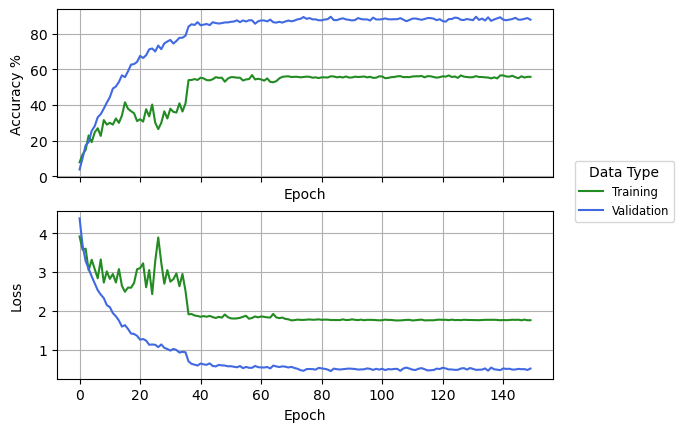

In [14]:
# Plot
fig, (ax_a, ax_l) = plt.subplots(2, sharex=True)

ax_a.set_xlabel("Epoch")
ax_a.set_ylabel("Accuracy %")
ax_a.plot(val_accuracies, c="forestgreen")
ax_a.plot(train_accuracies, c="royalblue")

ax_l.set_xlabel("Epoch")
ax_l.set_ylabel("Loss")
ax_l.plot(val_losses, c="forestgreen")
ax_l.plot(train_losses, c="royalblue")

fig.legend(title="Data Type", labels=["Training", "Validation"], fontsize="small", loc=3, bbox_to_anchor=(0.925, 0.425))
fig.align_labels()
plt.show()